# Uncertainty Estimation Notebook (Foundations)

This notebook will introduce you to unceratinty estimatiton using neural networks. It is highly inpsired by JavierAntoran's Bayesian-Neural-Networks GITHUB [repo](https://github.com/JavierAntoran/Bayesian-Neural-Networks/blob/master/README.md#bayes-by-backprop-bbp). 

We will use Gaussian processes as the backbone to create functions with ground truth uncertainty in them. We will model different types of uncertainties.

A sequence (or a vector) of random variables is denoted homoscedastic if all its random variables have the same finite variance - also known as homogeneity of variance. 

The complementary notion is called heteroscedasticity, where the assumption is that there are sub-populations of random variables that have different variabilities from others.

# Getting set up

Let's start by installing and importing all packages we need, including GPy for gaussian processes.

In [1]:

! pip install GPy
import GPy
import time
import copy
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Optimizer
from torch.optim.sgd import SGD

from tqdm import tqdm, trange
#from google.colab import files
%config InlineBackend.figure_format = 'svg'

     |████████████████████████████████| 1.0MB 9.0MB/s 
     |████████████████████████████████| 71kB 10.0MB/s 
  Created wheel for GPy: filename=GPy-1.9.9-cp37-cp37m-linux_x86_64.whl size=2626992 sha256=613aac1974fd0745fa94ce557eec0fe1a26707a8d9239ec05ca72b2f5bc5cae0
  Stored in directory: /root/.cache/pip/wheels/5d/36/66/2b58860c84c9f2b51615da66bfd6feeddbc4e04d887ff96dfa
  Created wheel for paramz: filename=paramz-0.9.5-cp37-none-any.whl size=102552 sha256=d5b1d06bba1f0ea17aa055e6dc7ad280e9d45b190a758e93e4e889b2f8b92053
  Stored in directory: /root/.cache/pip/wheels/c8/4a/0e/6e0dc85541825f991c431619e25b870d4b812c911214690cf8
Successfully built GPy paramz


In [2]:
def to_variable(var=(), cuda=True, volatile=False):
    out = []
    for v in var:
        
        if isinstance(v, np.ndarray):
            v = torch.from_numpy(v).type(torch.FloatTensor)

        if not v.is_cuda and cuda:
            v = v.cuda()

        if not isinstance(v, Variable):
            v = Variable(v, volatile=volatile)

        out.append(v)
    return out

Let's now define the Gaussian loss between output (x) and target ($\mu$), given a covariance matrix $\Sigma$ and $k$ dimensions



$\Large{\displaystyle (2\pi )^{-{\frac {k}{2}}}\det({\boldsymbol {\Sigma }})^{-{\frac {1}{2}}}\,e^{-{\frac {1}{2}}(\mathbf {x} -{\boldsymbol {\mu }})^{\!{\mathsf {T}}}{\boldsymbol {\Sigma }}^{-1}(\mathbf {x} -{\boldsymbol {\mu }})},}$


In [3]:
def log_gaussian_loss(output, target, sigma, no_dim):
    # To ensure non-negativity of the gaussian loss, let's define it in log space
    # Take the log of the gaussian function and estimate the log of the exponent and the log of the coefficient
    # TODO
    exponent = -0.5*(target - output)**2/sigma**2
    log_coeff = -no_dim*torch.log(sigma)
    
    return -(log_coeff + exponent).sum()


def get_kl_divergence(weights, prior, varpost):
    prior_loglik = prior.loglik(weights)
    
    varpost_loglik = varpost.loglik(weights)
    varpost_lik = varpost_loglik.exp()
    
    return (varpost_lik*(varpost_loglik - prior_loglik)).sum()


class gaussian:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
    def loglik(self, weights):
        # Do the same as a
        exponent = -0.5*(weights - self.mu)**2/self.sigma**2
        log_coeff = -0.5*(np.log(2*np.pi) + 2*np.log(self.sigma))
        
        return (exponent + log_coeff).sum()

# Part 0 - Generating a Ground Truth with GP

Let's first generate a function with some ground truth variance

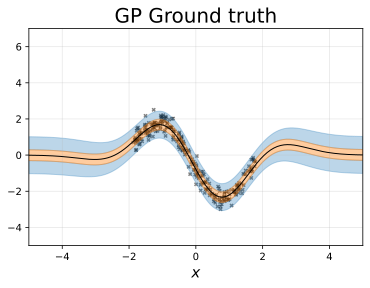

In [22]:
np.random.seed(2)
number_of_points = 400 
lengthscale = 1 #the smoothness of the function
variance = 1.0 # the variance of the random variable (Epistemic)
sig_noise = 0.3 # extra noise on top of the random variable noise (Aleatoric)
x = np.random.uniform(-3, 3, number_of_points)[:, None]
x.sort(axis = 0)

# First let's generate the data
k = GPy.kern.RBF(input_dim = 1, variance = variance, lengthscale = lengthscale)
C = k.K(x, x) + np.eye(number_of_points)*sig_noise**2
y = np.random.multivariate_normal(np.zeros((number_of_points)), C)[:, None]
y = (y - y.mean())

# Get the central points of vector given the number_of_points above
# E.g. remove the first and last 75 points
# TODO
x_train = x[75:325]
y_train = y[75:325]

# Now let's fit is assuming a RBF kernel plus white noise
rbf = GPy.kern.RBF(input_dim=1, variance=1, lengthscale=1.)
white = GPy.kern.White(input_dim=1, variance = 0.09)
m = GPy.models.GPRegression(x_train, y_train, rbf + white)

means, total_unc = m.predict(np.linspace(-5, 5, 200)[:, None])
means = means.reshape(-1)
aleatoric = m.parameters[0].white.parameters[0][0]**0.5
total_unc = (total_unc/2).reshape(-1)**0.5

# The epistemic uncertainty is the total uncertainty minus the aletoric one
# TODO
epistemic = (total_unc**2 - aleatoric**2)**0.5


plt.scatter(x_train, y_train, s = 10, marker = 'x', color = 'black', alpha = 0.5)
plt.fill_between(np.linspace(-5, 5, 200), means + aleatoric, means + total_unc, color = '#1f77b4', alpha = 0.3, label = 'Epistemic + Aleatoric')
plt.fill_between(np.linspace(-5, 5, 200), means - total_unc, means - aleatoric, color = '#1f77b4', alpha = 0.3)
plt.fill_between(np.linspace(-5, 5, 200), means - aleatoric, means + aleatoric, color = '#ff7f0e', alpha = 0.4, label = 'Aleatoric')
plt.plot(np.linspace(-5, 5, 200), means, color = 'black', linewidth = 1)
plt.xlim([-5, 5])
plt.ylim([-5, 7])
plt.xlabel('$x$', fontsize=15)
plt.title('GP Ground truth', fontsize=20)
plt.tick_params(labelsize=10)
plt.xticks(np.arange(-4, 5, 2))
plt.yticks(np.arange(-4, 7, 2))
plt.gca().yaxis.grid(alpha=0.3)
plt.gca().xaxis.grid(alpha=0.3)
plt.show()

# Part 1 - Bayes by Backprop - Homoscedastic

This section is based on the work of Blundell et al. ICML 2015

https://arxiv.org/pdf/1505.05424.pdf

In this work, the weights themselves have an uncertainty associated with them.

Now please read section 3.2 of the paper.
Let's implement the bayes layer and the forward pass. 



In [5]:
class BayesLinear_Normalq(nn.Module):
    def __init__(self, input_dim, output_dim, prior):
        super(BayesLinear_Normalq, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.prior = prior
        
        scale = (2/self.input_dim)**0.5
        rho_init = np.log(np.exp((2/self.input_dim)**0.5) - 1)
        # Initialise the MUs weights and biases as a uniform(-0.05,0.05) and
        # the RHOs weights and biases as a uniform(-2,-1)
        self.weight_mus = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-0.05, 0.05))
        self.weight_rhos = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-2, -1))
        self.bias_mus = nn.Parameter(torch.Tensor(self.output_dim).uniform_(-0.05, 0.05))
        self.bias_rhos = nn.Parameter(torch.Tensor(self.output_dim).uniform_(-2, -1))
        
    def forward(self, x, sample = True):
        
        if sample:
            # Implement the sampling scheme of section 3.2 of the paper, namely steps 1 and 2
            # sample gaussian noise for each weight and each bias 
            # TODO
            weight_epsilons = Variable(self.weight_mus.data.new(self.weight_mus.size()).normal_())
            bias_epsilons =  Variable(self.bias_mus.data.new(self.bias_mus.size()).normal_())
            
            # calculate the weight and bias stds from the rho parameters
            # TODO
            weight_stds = torch.log(1 + torch.exp(self.weight_rhos))
            bias_stds = torch.log(1 + torch.exp(self.bias_rhos))
            
            # calculate samples from the posterior from the sampled noise and mus/stds
            # TODO
            weight_sample = self.weight_mus + weight_epsilons*weight_stds
            bias_sample = self.bias_mus + bias_epsilons*bias_stds
            
            # Now add build the fully connected layer with the weight and bias samples
            # TODO
            output = torch.mm(x, weight_sample) + bias_sample
            
            # Computing the KL loss term for the weights
            prior_cov, varpost_cov = self.prior.sigma**2, weight_stds**2
            KL_loss = 0.5*(torch.log(prior_cov/varpost_cov)).sum() - 0.5*weight_stds.numel()
            KL_loss = KL_loss + 0.5*(varpost_cov/prior_cov).sum()
            KL_loss = KL_loss + 0.5*((self.weight_mus - self.prior.mu)**2/prior_cov).sum()
            
            # Now add the KL loss term for the biases
            prior_cov, varpost_cov = self.prior.sigma**2, bias_stds**2
            KL_loss = KL_loss + 0.5*(torch.log(prior_cov/varpost_cov)).sum() - 0.5*bias_stds.numel()
            KL_loss = KL_loss + 0.5*(varpost_cov/prior_cov).sum()
            KL_loss = KL_loss + 0.5*((self.bias_mus - self.prior.mu)**2/prior_cov).sum()
            
            return output, KL_loss
        
        else:
            output = torch.mm(x, self.weight_mus) + self.bias_mus
            return output, KL_loss
        
    def sample_layer(self, no_samples):
        all_samples = []
        for i in range(no_samples):
            # sample gaussian noise for each weight and each bias
            weight_epsilons = Variable(self.weight_mus.data.new(self.weight_mus.size()).normal_())
            
            # calculate the weight and bias stds from the rho parameters
            weight_stds = torch.log(1 + torch.exp(self.weight_rhos))
            
            # calculate samples from the posterior from the sampled noise and mus/stds
            weight_sample = self.weight_mus + weight_epsilons*weight_stds
            all_samples += weight_sample.view(-1).cpu().data.numpy().tolist()
            
        return all_samples

Now write the actual model itself and wrap it in a single function


In [8]:
class BBP_Homoscedastic_Model(nn.Module):
    def __init__(self, input_dim, output_dim, no_units, init_log_noise):
        super(BBP_Homoscedastic_Model, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # network with two hidden and one output layer
        # TODO
        self.layer1 = BayesLinear_Normalq(input_dim, no_units, gaussian(0, 1))
        self.layer2 = BayesLinear_Normalq(no_units, output_dim, gaussian(0, 1))
        
        # activation to be used between hidden layers
        self.activation = nn.ReLU(inplace = True)
        self.log_noise = nn.Parameter(torch.cuda.FloatTensor([init_log_noise]))

    
    def forward(self, x):
        # Now let's implement the network as a layer->actiavation->layer 
        # Dont forget to collect the KL_Loss as it is generated by each layer
        # TODO
        KL_loss_total = 0
        x = x.view(-1, self.input_dim)
        
        x, KL_loss = self.layer1(x)
        KL_loss_total = KL_loss_total + KL_loss
        x = self.activation(x)
        
        x, KL_loss = self.layer2(x)
        KL_loss_total = KL_loss_total + KL_loss
        
        return x, KL_loss_total


class BBP_Homoscedastic_Model_Wrapper:
    def __init__(self, input_dim, output_dim, no_units, learn_rate, batch_size, no_batches, init_log_noise):
        
        self.learn_rate = learn_rate
        self.batch_size = batch_size
        self.no_batches = no_batches
        
        self.network = BBP_Homoscedastic_Model(input_dim = input_dim, output_dim = output_dim,
                                               no_units = no_units, init_log_noise = init_log_noise)
        self.network.cuda()
        
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr = self.learn_rate)
        self.loss_func = log_gaussian_loss
    
    def fit(self, x, y, no_samples):
        x, y = to_variable(var=(x, y), cuda=True)
        
        self.optimizer.zero_grad()
        fit_loss_total = 0
        
        for i in range(no_samples):
            output, KL_loss_total = self.network(x)

            # calculate fit loss based on mean and standard deviation of output
            fit_loss_total = fit_loss_total + self.loss_func(output, y, self.network.log_noise.exp(), self.network.output_dim)
        
        KL_loss_total = KL_loss_total/self.no_batches
        total_loss = (fit_loss_total + KL_loss_total)/(no_samples*x.shape[0])
        total_loss.backward()
        self.optimizer.step()

        return fit_loss_total/no_samples, KL_loss_total

Train the model


In [9]:
np.random.seed(2)
no_points = 400
lengthscale = 1.0
variance = 1.0
sig_noise = 0.3
x = np.random.uniform(-3, 3, no_points)[:, None]
x.sort(axis = 0)


k = GPy.kern.RBF(input_dim = 1, variance = variance, lengthscale = lengthscale)
C = k.K(x, x) + np.eye(no_points)*sig_noise**2

y = np.random.multivariate_normal(np.zeros((no_points)), C)[:, None]
y = (y - y.mean())
x_train = x[75:325]
y_train = y[75:325]

x_mean, x_std = x_train.mean(), x_train.var()**0.5
y_mean, y_std = y_train.mean(), y_train.var()**0.5

x_train = (x_train - x_mean)/x_std
y_train = (y_train - y_mean)/y_std


num_epochs, batch_size, nb_train = 2000, len(x_train), len(x_train)

net = BBP_Homoscedastic_Model_Wrapper(input_dim = 1, output_dim = 1, no_units = 100, learn_rate = 1e-1,
                                      batch_size = batch_size, no_batches = 1, init_log_noise = 0)

fit_loss_train = np.zeros(num_epochs)
KL_loss_train = np.zeros(num_epochs)
total_loss = np.zeros(num_epochs)

best_net, best_loss = None, float('inf')

for i in range(num_epochs):
    
    fit_loss, KL_loss = net.fit(x_train, y_train, no_samples = 10)
    fit_loss_train[i] += fit_loss.cpu().data.numpy()
    KL_loss_train[i] += KL_loss.cpu().data.numpy()
    
    total_loss[i] = fit_loss_train[i] + KL_loss_train[i]
    
    if fit_loss < best_loss:
        best_loss = fit_loss
        best_net = copy.deepcopy(net.network)
        
    if i % 100 == 0 or i == num_epochs - 1:
        
        print("Epoch: %5d/%5d, Fit loss = %8.3f, KL loss = %8.3f, noise = %6.3f" %
              (i + 1, num_epochs, fit_loss_train[i], KL_loss_train[i], net.network.log_noise.exp().cpu().data.numpy()))

        samples = []
        for i in range(100):
            preds = net.network.forward(torch.linspace(-3, 3, 200).cuda())[0]
            samples.append(preds.cpu().data.numpy()[:, 0])

Epoch:     1/ 2000, Fit loss =  182.504, KL loss =  341.089, noise =  1.105
Epoch:   101/ 2000, Fit loss = -260.857, KL loss =  553.039, noise =  0.202
Epoch:   201/ 2000, Fit loss = -266.354, KL loss =  554.173, noise =  0.214
Epoch:   301/ 2000, Fit loss = -261.331, KL loss =  550.252, noise =  0.195
Epoch:   401/ 2000, Fit loss = -269.434, KL loss =  590.312, noise =  0.214
Epoch:   501/ 2000, Fit loss = -280.131, KL loss =  626.388, noise =  0.207
Epoch:   601/ 2000, Fit loss = -276.218, KL loss =  585.747, noise =  0.219
Epoch:   701/ 2000, Fit loss = -272.280, KL loss =  627.891, noise =  0.209
Epoch:   801/ 2000, Fit loss = -274.874, KL loss =  632.167, noise =  0.206
Epoch:   901/ 2000, Fit loss = -270.480, KL loss =  659.875, noise =  0.204
Epoch:  1001/ 2000, Fit loss = -267.640, KL loss =  669.538, noise =  0.209
Epoch:  1101/ 2000, Fit loss = -279.691, KL loss =  637.482, noise =  0.202
Epoch:  1201/ 2000, Fit loss = -268.153, KL loss =  645.720, noise =  0.200
Epoch:  1301

And Finally test it 

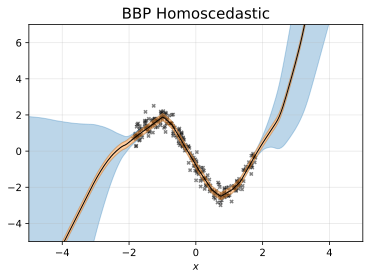

In [10]:
samples = []
for i in range(100):
    preds = (best_net.forward(torch.linspace(-5, 5, 200).cuda())[0] * y_std) + y_mean
    samples.append(preds.cpu().data.numpy()[:, 0])

samples = np.array(samples)
means = samples.mean(axis = 0)

aleatoric = best_net.log_noise.exp().cpu().data.numpy()
epistemic = samples.var(axis = 0)**0.5
total_unc = (aleatoric**2 + epistemic**2)**0.5



plt.scatter((x_train * x_std) + x_mean, (y_train * y_std) + y_mean, s = 10, marker = 'x', color = 'black', alpha = 0.5)
plt.fill_between(np.linspace(-5, 5, 200)*x_std + x_mean, means + aleatoric, means + total_unc, color = '#1f77b4', alpha = 0.3, label = r'$\sigma(y^*|x^*)$')
plt.fill_between(np.linspace(-5, 5, 200)*x_std + x_mean, means - total_unc, means - aleatoric, color = '#1f77b4', alpha = 0.3)
plt.fill_between(np.linspace(-5, 5, 200)*x_std + x_mean, means - aleatoric, means + aleatoric, color = '#ff7f0e', alpha = 0.4, label = r'$\EX[\sigma^2]^{1/2}$')
plt.plot(np.linspace(-5, 5, 200)*x_std + x_mean, means, color = 'black', linewidth = 1)
plt.xlim([-5, 5])
plt.ylim([-5, 7])
plt.xlabel('$x$', fontsize=10)
plt.title('BBP Homoscedastic', fontsize=15)
plt.tick_params(labelsize=10)
plt.xticks(np.arange(-4, 5, 2))
plt.gca().yaxis.grid(alpha=0.3)
plt.gca().xaxis.grid(alpha=0.3)


plt.show()

# Part 2 - Bayes by Backprop - Heteroscedastic

Now let's the same for the heteroscedastic model

In [11]:
class BBP_Heteroscedastic_Model(nn.Module):
    def __init__(self, input_dim, output_dim, num_units):
        super(BBP_Heteroscedastic_Model, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # Network with two hidden and one output layer
        # Note that we now want 2 outputs, one for the prediction and one for the variance
        # TODO
        self.layer1 = BayesLinear_Normalq(input_dim, num_units, gaussian(0, 1))
        self.layer2 = BayesLinear_Normalq(num_units, 2*output_dim, gaussian(0, 1))
        
        # Activation to be used between hidden layers
        self.activation = nn.ReLU(inplace = True)
    
    def forward(self, x):
        
        KL_loss_total = 0
        x = x.view(-1, self.input_dim)
        
        x, KL_loss = self.layer1(x)
        KL_loss_total = KL_loss_total + KL_loss
        x = self.activation(x)
        
        x, KL_loss = self.layer2(x)
        KL_loss_total = KL_loss_total + KL_loss
        
        return x, KL_loss_total

class BBP_Heteroscedastic_Model_Wrapper:
    def __init__(self, network, learn_rate, batch_size, no_batches):
        
        self.learn_rate = learn_rate
        self.batch_size = batch_size
        self.no_batches = no_batches
        
        self.network = network
        self.network.cuda()
        
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr = self.learn_rate)
        self.loss_func = log_gaussian_loss
    
    def fit(self, x, y, no_samples):
        x, y = to_variable(var=(x, y), cuda=True)
        
        # reset gradient and total loss
        self.optimizer.zero_grad()
        fit_loss_total = 0
        
        for i in range(no_samples):
            output, KL_loss_total = self.network(x)

            # calculate fit loss based on mean and standard deviation of output
            # TODO
            fit_loss = self.loss_func(output[:, :1], y, output[:, 1:].exp(), 1)
            fit_loss_total = fit_loss_total + fit_loss
        
        KL_loss_total = KL_loss_total/self.no_batches
        total_loss = (fit_loss_total + KL_loss_total)/(no_samples*x.shape[0])
        total_loss.backward()
        self.optimizer.step()

        return fit_loss_total/no_samples, KL_loss_total
    
    def get_loss_and_rmse(self, x, y, no_samples):
        x, y = to_variable(var=(x, y), cuda=True)
        
        means, stds = [], []
        for i in range(no_samples):
            output, KL_loss_total = self.network(x)
            means.append(output[:, :1, None])
            stds.append(output[:, 1:, None].exp())
            
        means, stds = torch.cat(means, 2), torch.cat(stds, 2)
        # Calculate the mean of the means, 
        # and the variance of the mean + the mean of the variances
        # TODO
        mean = means.mean(dim=2)
        std = (means.var(dim=2) + stds.mean(dim=2)**2)**0.5
            
        # calculate fit loss based on mean and standard deviation of output
        # TODO
        logliks = self.loss_func(output[:, :1], y, output[:, 1:].exp(), 1, sum_reduce=False)
        rmse = float((((mean - y)**2).mean()**0.5).cpu().data)

        return logliks, rmse

Lastly, let's train it and see the outcome
Compare to the other networks. What do you see?

In [12]:
np.random.seed(2)
no_points = 400
lengthscale = 1
variance = 1.0
sig_noise = 0.3
x = np.random.uniform(-3, 3, no_points)[:, None]
x.sort(axis = 0)

k = GPy.kern.RBF(input_dim = 1, variance = variance, lengthscale = lengthscale)
C = k.K(x, x) + np.eye(no_points)*(x + 2)**2*sig_noise**2

y = np.random.multivariate_normal(np.zeros((no_points)), C)[:, None]
y = (y - y.mean())
x_train = x[75:325]
y_mean = y[75:325].mean()
y_std = y[75:325].var()**0.5
y_train = (y[75:325] - y_mean)/y_std


num_epochs, batch_size, nb_train = 2000, len(x_train), len(x_train)

net = BBP_Heteroscedastic_Model_Wrapper(network=BBP_Heteroscedastic_Model(input_dim=1, output_dim=1, num_units=200),
                                        learn_rate=1e-2, batch_size=batch_size, no_batches=1)

fit_loss_train = np.zeros(num_epochs)
KL_loss_train = np.zeros(num_epochs)
total_loss = np.zeros(num_epochs)

best_net, best_loss = None, float('inf')

for i in range(num_epochs):
    
    fit_loss, KL_loss = net.fit(x_train, y_train, no_samples = 10)
    fit_loss_train[i] += fit_loss.cpu().data.numpy()
    KL_loss_train[i] += KL_loss.cpu().data.numpy()
    
    total_loss[i] = fit_loss_train[i] + KL_loss_train[i]
    
    if fit_loss < best_loss:
        best_loss = fit_loss
        best_net = copy.deepcopy(net.network)
        
    if i % 100 == 0 or i == num_epochs - 1:
        
        print("Epoch: %5d/%5d, Fit loss = %7.3f, KL loss = %8.3f" %
              (i + 1, num_epochs, fit_loss_train[i], KL_loss_train[i]))

        samples = []
        for i in range(100):
            preds = net.network.forward(torch.linspace(-3, 3, 200).cuda())[0]
            samples.append(preds.cpu().data.numpy()[:, 0])

Epoch:     1/ 2000, Fit loss = 304.681, KL loss =  902.544
Epoch:   101/ 2000, Fit loss = 150.530, KL loss =  974.523
Epoch:   201/ 2000, Fit loss =  31.410, KL loss = 1024.924
Epoch:   301/ 2000, Fit loss = -41.011, KL loss = 1054.731
Epoch:   401/ 2000, Fit loss = -99.338, KL loss = 1082.491
Epoch:   501/ 2000, Fit loss = -130.304, KL loss = 1099.926
Epoch:   601/ 2000, Fit loss = -146.603, KL loss = 1116.962
Epoch:   701/ 2000, Fit loss = -191.992, KL loss = 1123.404
Epoch:   801/ 2000, Fit loss = -203.160, KL loss = 1121.956
Epoch:   901/ 2000, Fit loss = -203.043, KL loss = 1108.725
Epoch:  1001/ 2000, Fit loss = -210.406, KL loss = 1093.180
Epoch:  1101/ 2000, Fit loss = -212.441, KL loss = 1071.649
Epoch:  1201/ 2000, Fit loss = -183.383, KL loss = 1048.046
Epoch:  1301/ 2000, Fit loss = -214.954, KL loss = 1024.004
Epoch:  1401/ 2000, Fit loss = -209.634, KL loss = 1000.845
Epoch:  1501/ 2000, Fit loss = -215.470, KL loss =  976.800
Epoch:  1601/ 2000, Fit loss = -214.728, KL l

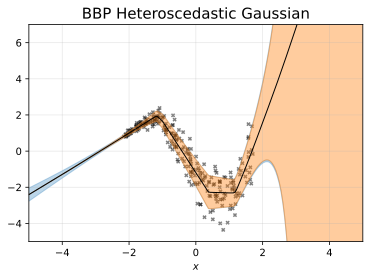

In [13]:
samples, noises = [], []
for i in range(100):
    preds = best_net.forward(torch.linspace(-5, 5, 200).cuda())[0]
    samples.append(preds[:, 0].cpu().data.numpy()* y_std + y_mean)
    noises.append(preds[:, 1].exp().cpu().data.numpy()* y_std)

samples = np.array(samples)
noises = np.array(noises)
means = samples.mean(axis = 0)

aleatoric = (noises**2).mean(axis = 0)**0.5
epistemic = samples.var(axis = 0)**0.5
aleatoric = np.minimum(aleatoric, 10e3)
epistemic = np.minimum(epistemic, 10e3)

total_unc = (aleatoric**2 + epistemic**2)**0.5

x_mean, x_std = x_train.mean(), x_train.var()**0.5

plt.scatter(x_train * x_std + x_mean, y_train * y_std + y_mean, s = 10, marker = 'x', color = 'black', alpha = 0.5)
plt.fill_between(np.linspace(-5, 5, 200)* x_std + x_mean, means + aleatoric, means + total_unc, color = '#1f77b4', alpha = 0.3, label = 'Epistemic + Aleatoric')
plt.fill_between(np.linspace(-5, 5, 200)* x_std + x_mean, means - total_unc, means - aleatoric, color = '#1f77b4', alpha = 0.3)
plt.fill_between(np.linspace(-5, 5, 200)* x_std + x_mean, means - aleatoric, means + aleatoric, color = '#ff7f0e', alpha = 0.4, label = 'Aleatoric')
plt.plot(np.linspace(-5, 5, 200)* x_std + x_mean, means, color = 'black', linewidth = 1)
plt.xlim([-5, 5])
plt.ylim([-5, 7])
plt.xlabel('$x$', fontsize=10)
plt.title('BBP Heteroscedastic Gaussian', fontsize=15)
plt.tick_params(labelsize=10)
plt.xticks(np.arange(-4, 5, 2))
plt.yticks(np.arange(-4, 7, 2))
plt.gca().yaxis.grid(alpha=0.3)
plt.gca().xaxis.grid(alpha=0.3)

plt.show()

**QUESTION ->** How do different networks react to different parameters of no_points, lengthscale, variance, sig_noise?

# Part 3 - Homoscedastic model
How to repruduce the above with neural networks?

Let's use Yarin Gal's Dropout-based approximation.

First, let's start by implementing a Dropout layer by yourself

In [14]:
class MC_Dropout_Layer(nn.Module):
    def __init__(self, input_dim, output_dim, dropout_prob):
        super(MC_Dropout_Layer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.dropout_prob = dropout_prob
        
        # Initialise the parameters to some uniformely distributed values close to zero
        # TODO
        self.weights = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-0.01, 0.01))
        self.biases = nn.Parameter(torch.Tensor(self.output_dim).uniform_(-0.01, 0.01))
        
    def forward(self, x):
        
        # Now let's define the dropout mask as a bernouly distribution of size self.weights.shape
        # where the probability is (1 - self.dropout_prob) 
        # TODO
        dropout_mask = torch.bernoulli((1 - self.dropout_prob)*torch.ones(self.weights.shape)).cuda()
        
        # Finally, let's return the masked weights
        # TODO
        return torch.mm(x, self.weights*dropout_mask) + self.biases

Now implement the homoscedastic model using either your layer or, if you prefer, the pytorch dropout layer. 

In [15]:
class MC_Dropout_Model(nn.Module):
    def __init__(self, input_dim, output_dim, no_units, init_log_noise, drop_prob):
        super(MC_Dropout_Model, self).__init__()
        
        self.input_dim = input_dim
        self.drop_prob = drop_prob
        self.output_dim = output_dim

        # Our networ will be a 2 layer fully connected neural network 
        # Define it below
        # TODO 
        self.layer1 = nn.Linear(input_dim, no_units)
        self.layer2 = nn.Linear(no_units, output_dim)
        
        # activation to be used between hidden layers
        self.activation = nn.ReLU(inplace = True)
        self.log_noise = nn.Parameter(torch.cuda.FloatTensor([init_log_noise]))

    
    def forward(self, x):
        
        x = x.view(-1, self.input_dim)
        
        # Now link it all up
        # It should be x -> layer1 -> activation -> dropout -> layer 2 -> output
        # TODO
        x = self.layer1(x)
        x = self.activation(x)
        
        x = F.dropout(x, p=self.drop_prob, training=True)
        
        x = self.layer2(x)
        
        return x

Now that we have the homoscedastic model, let's wrap the model to make it easier to train with one single line. 

In [16]:
class MC_Dropout_Homoscedastic_Wrapper:
    def __init__(self, input_dim, output_dim, no_units, learn_rate, batch_size, no_batches, weight_decay, init_log_noise, drop_prob):
        
        self.learn_rate = learn_rate
        self.drop_prob  = drop_prob
        self.batch_size = batch_size
        self.no_batches = no_batches
        
        self.network = MC_Dropout_Model(input_dim = input_dim, output_dim = output_dim,
                                        no_units = no_units, init_log_noise = init_log_noise,
                                        drop_prob = drop_prob)
        self.network.cuda()
        
        self.optimizer = torch.optim.SGD(self.network.parameters(), lr=learn_rate, weight_decay=weight_decay)
        self.loss_func = log_gaussian_loss
    
    def fit(self, x, y):
        x, y = to_variable(var=(x, y), cuda=True)
        
        # Reset gradient and total loss
        self.optimizer.zero_grad()
        
        # Now get the output for the network and calculate the loss 
        # (dont forget to devide by the lenght of the output vector)
        # TODO

        output = self.network(x)
        loss = self.loss_func(output, y, torch.exp(self.network.log_noise), 1)/len(x)
        
        loss.backward()
        self.optimizer.step()

        return loss

Finally, we are going to train MC Homoscedastic model using a similar generative model to the GP one above

In [17]:
np.random.seed(2)
no_points = 400
lengthscale = 1
variance = 1.0
sig_noise = 0.3
x = np.random.uniform(-3, 3, no_points)[:, None]
x.sort(axis = 0)


k = GPy.kern.RBF(input_dim = 1, variance = variance, lengthscale = lengthscale)
C = k.K(x, x) + np.eye(no_points)*sig_noise**2

y = np.random.multivariate_normal(np.zeros((no_points)), C)[:, None]
y = (y - y.mean())
x_train = x[75:325]
y_train = y[75:325]

num_epochs, batch_size, nb_train = 2000, len(x_train), len(x_train)

net = MC_Dropout_Homoscedastic_Wrapper(input_dim = 1, output_dim=1, no_units=200, 
                                       learn_rate=1e-2, batch_size=batch_size, no_batches=1, 
                                       init_log_noise=0, weight_decay=1e-2,drop_prob=0.5)

for i in range(num_epochs):
    
    loss = net.fit(x_train, y_train)
    
    if i % 200 == 0:
        print('Epoch: %4d, Train loss = %7.3f, noise = %6.3f' % \
              (i, loss.cpu().data.numpy(), torch.exp(net.network.log_noise).cpu().data.numpy()))

Epoch:    0, Train loss =   1.487, noise =  1.020
Epoch:  200, Train loss =   0.141, noise =  0.748
Epoch:  400, Train loss =   0.142, noise =  0.662
Epoch:  600, Train loss =   0.003, noise =  0.624
Epoch:  800, Train loss =   0.017, noise =  0.595
Epoch: 1000, Train loss =  -0.013, noise =  0.583
Epoch: 1200, Train loss =  -0.123, noise =  0.567
Epoch: 1400, Train loss =  -0.063, noise =  0.555
Epoch: 1600, Train loss =  -0.142, noise =  0.550
Epoch: 1800, Train loss =  -0.178, noise =  0.543


Let's print the model predictions

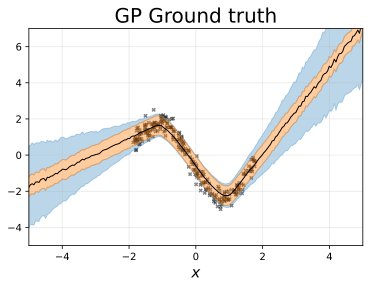

In [18]:
samples = []
noises = []

# What would the network predict for an input with linspace(-5, 5, 200)?
for i in range(1000):
    # TODO 
    # (Don't forget to run on GPU, move to CPU, and then convert to numpy)
    preds = net.network.forward(torch.linspace(-5, 5, 200).cuda()).cpu().data.numpy()
    samples.append(preds)
    
samples = np.array(samples)
means = (samples.mean(axis = 0)).reshape(-1)
aleatoric = torch.exp(net.network.log_noise).cpu().data.numpy()
epistemic = (samples.var(axis = 0)**0.5).reshape(-1)
total_unc = (aleatoric**2 + epistemic**2)**0.5

plt.scatter(x_train, y_train, s = 10, marker = 'x', color = 'black', alpha = 0.5)
plt.fill_between(np.linspace(-5, 5, 200), means + aleatoric, means + total_unc, color = '#1f77b4', alpha = 0.3, label = 'Epistemic + Aleatoric')
plt.fill_between(np.linspace(-5, 5, 200), means - total_unc, means - aleatoric, color = '#1f77b4', alpha = 0.3)
plt.fill_between(np.linspace(-5, 5, 200), means - aleatoric, means + aleatoric, color = '#ff7f0e', alpha = 0.4, label = 'Aleatoric')
plt.plot(np.linspace(-5, 5, 200), means, color = 'black', linewidth = 1)
plt.xlim([-5, 5])
plt.ylim([-5, 7])
plt.xlabel('$x$', fontsize=15)
plt.title('GP Ground truth', fontsize=20)
plt.tick_params(labelsize=10)
plt.xticks(np.arange(-4, 5, 2))
plt.yticks(np.arange(-4, 7, 2))
plt.gca().yaxis.grid(alpha=0.3)
plt.gca().xaxis.grid(alpha=0.3)
plt.show()

# Part 4 - Heteroscedastic model
Now lets to the same thing for the Heteroscedastic model.
Wrap it again around a function to amke it easier to train

In [19]:
class MC_Dropout_Heteroscedastic_Wrapper:
    def __init__(self, network, learn_rate, batch_size, weight_decay):
        
        self.learn_rate = learn_rate
        self.batch_size = batch_size
        
        self.network = network
        self.network.cuda()
        
        self.optimizer = torch.optim.SGD(self.network.parameters(), lr=learn_rate, weight_decay=weight_decay)
        self.loss_func = log_gaussian_loss
    
    def fit(self, x, y):
        x, y = to_variable(var=(x, y), cuda=True)
        
        # reset gradient and total loss
        self.optimizer.zero_grad()
        
        output = self.network(x)
        # The loss here will be similar to the homoscedastic one, 
        # but we have a per sample variance predicted from output
        # TODO
        loss = self.loss_func(output[:, :1], y, output[:, 1:].exp(), 1)
        
        loss.backward()
        self.optimizer.step()

        return loss
    
    def get_loss_and_rmse(self, x, y, num_samples):
        x, y = to_variable(var=(x, y), cuda=True)
        
        means, stds = [], []
        # Let's fetch the mean and variance predictions from the network
        # they will be stored as two 1D vectors
        for i in range(num_samples):
            output = self.network(x)
            # TODO
            means.append(output[:, :1])
            stds.append(output[:, 1:].exp())
        
        means, stds = torch.cat(means, dim=1), torch.cat(stds, dim=1)
        mean = means.mean(dim=-1)[:, None]
        
        # The total STD equals the variance of the mean plus the mean predicted variance
        # TODO
        std = ((means.var(dim=-1) + stds.mean(dim=-1)**2)**0.5)[:, None]
        loss = self.loss_func(mean, y, std, 1)
        
        rmse = ((mean - y)**2).mean()**0.5

        return loss.detach().cpu(), rmse.detach().cpu()

Let's now train the model, but first, we need to change the generative model so that the noise variance changes at each location X

In [20]:
np.random.seed(2)
no_points = 400
lengthscale = 1
variance = 1.0
sig_noise = 0.3

# X is a uniform variable between -3 and 3
# which will be sorted to give us a varying X
# TODO
x = np.random.uniform(-3, 3, no_points)[:, None]
x.sort(axis = 0)


k = GPy.kern.RBF(input_dim=1, variance=variance, lengthscale=lengthscale)
# Now let's increase the variance of C by (x + 2)^2 multiplied by a fixed sigma noise
# TODO
C = k.K(x, x) + np.eye(no_points)*(x + 2)**2*sig_noise**2

y = np.random.multivariate_normal(np.zeros((no_points)), C)[:, None]
y = (y - y.mean())
x_train = x[75:325]
y_train = y[75:325]

print(x_train.shape, y_train.shape)
num_epochs, batch_size = 4000, len(x_train)

net = MC_Dropout_Heteroscedastic_Wrapper(network=MC_Dropout_Model(input_dim=1, output_dim=2, 
                                                                  no_units=200, init_log_noise=0, 
                                                                  drop_prob=0.5),
                                         learn_rate=1e-4, 
                                         batch_size=batch_size, 
                                         weight_decay=1e-2)

fit_loss_train = np.zeros(num_epochs)
best_net, best_loss = None, float('inf')
nets, losses = [], []

for i in range(num_epochs):
    
    loss = net.fit(x_train, y_train)
    
    if i % 200 == 0:
        total_loss = net.get_loss_and_rmse(x_train, y_train,100)
        print('Epoch: %4d, Train loss = %7.3f, Total loss = %7.3f, RMSE = %7.3f' % (i, 
                                                                                    loss.cpu().data.numpy()/batch_size, 
                                                                                    total_loss[0], 
                                                                                    total_loss[1]))

(250, 1) (250, 1)
Epoch:    0, Train loss =   4.136, Total loss = 1988.054, RMSE =   1.712
Epoch:  200, Train loss =   0.419, Total loss = 163.033, RMSE =   1.179
Epoch:  400, Train loss =   0.139, Total loss =   2.214, RMSE =   0.753
Epoch:  600, Train loss =   0.619, Total loss = 111.120, RMSE =   0.910
Epoch:  800, Train loss =   0.071, Total loss =  -0.132, RMSE =   0.706
Epoch: 1000, Train loss =   0.148, Total loss = 128.471, RMSE =   0.893
Epoch: 1200, Train loss =   0.191, Total loss =  73.450, RMSE =   0.827
Epoch: 1400, Train loss =   0.381, Total loss =  37.359, RMSE =   0.683
Epoch: 1600, Train loss =   0.246, Total loss =  97.430, RMSE =   0.826
Epoch: 1800, Train loss =   0.304, Total loss =  43.289, RMSE =   0.712
Epoch: 2000, Train loss =  -0.037, Total loss = -26.763, RMSE =   0.659
Epoch: 2200, Train loss =  -0.092, Total loss = -42.248, RMSE =   0.667
Epoch: 2400, Train loss =  -0.078, Total loss = -39.990, RMSE =   0.667
Epoch: 2600, Train loss =  -0.109, Total loss

Before moving to the next section, play with the variance and sig_noise parameters and see the effect on the total loss and RMSE. Is there a relationship?

### Display
Display the results and compare to the homoscedastic section.

What differences do you see?


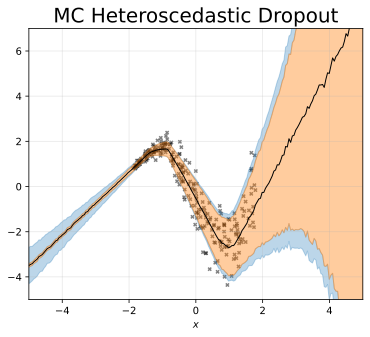

In [21]:
samples = []
noises = []
for i in range(1000):
    preds = net.network.forward(torch.linspace(-5, 5, 200).cuda()).cpu().data.numpy()
    samples.append(preds[:, 0])
    noises.append(np.exp(preds[:, 1]))
    
samples = np.array(samples)
noises = np.array(noises)
means = (samples.mean(axis = 0)).reshape(-1)
aleatoric = (noises**2).mean(axis = 0)**0.5
epistemic = (samples.var(axis = 0)**0.5).reshape(-1)
total_unc = (aleatoric**2 + epistemic**2)**0.5


plt.figure(figsize = (6, 5))
plt.scatter(x_train, y_train, s = 10, marker = 'x', color = 'black', alpha = 0.5)
plt.fill_between(np.linspace(-5, 5, 200), means + aleatoric, means + total_unc, color = '#1f77b4', alpha = 0.3, label = 'Epistemic + Aleatoric')
plt.fill_between(np.linspace(-5, 5, 200), means - total_unc, means - aleatoric, color = '#1f77b4', alpha = 0.3)
plt.fill_between(np.linspace(-5, 5, 200), means - aleatoric, means + aleatoric, color = '#ff7f0e', alpha = 0.4, label = 'Aleatoric')
plt.plot(np.linspace(-5, 5, 200), means, color = 'black', linewidth = 1)
plt.xlim([-5, 5])
plt.ylim([-5, 7])
plt.xlabel('$x$', fontsize=10)
plt.title('MC Heteroscedastic Dropout', fontsize=20)
plt.tick_params(labelsize=10)
plt.xticks(np.arange(-4, 5, 2))
plt.yticks(np.arange(-4, 7, 2))
plt.gca().yaxis.grid(alpha=0.3)
plt.gca().xaxis.grid(alpha=0.3)


plt.show()